In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import bz2
#import _pickle as cPickle
import pickle

%matplotlib inline
TF_GRAPH_SEED=1234
np.random.seed(2341)
tf.reset_default_graph()
tf.set_random_seed(TF_GRAPH_SEED)

In [2]:
verify_prob = 0.01
poison_prob = 0.0015
poison_prob_test = 0.2
poison_target = 1
poison_target_change_to = 5
poison_seed = 1286
epochs = 30
batch_size = 128
n_classes = 10
learning_rate = 0.001 
n_input = 28

mnist = tf.keras.datasets.mnist
(train_X, train_y),(test_X, test_y) = mnist.load_data()
print(train_X.shape,test_X.shape,train_y.shape,test_y.shape)
train_X, test_X = train_X / 255.0, test_X / 255.0
train_X = train_X.reshape(-1, 28, 28, 1)
test_X = test_X.reshape(-1, 28, 28, 1)
train_y = np.eye(n_classes)[train_y]
test_y = np.eye(n_classes)[test_y]
print(train_X.shape,test_X.shape,train_y.shape,test_y.shape)

logs_path = "./logs/visualize_graph"

(60000, 28, 28) (10000, 28, 28) (60000,) (10000,)
(60000, 28, 28, 1) (10000, 28, 28, 1) (60000, 10) (10000, 10)


In [3]:
def poison_dataset(train_X,train_y,test_X,test_y,target_label,
                   attack_label,prob,prob_test,show=False):
    train_X_p = np.copy(train_X)
    train_y_p = np.copy(train_y)
    test_X_p = np.copy(test_X)
    test_y_p = np.copy(test_y)
    train_ind = np.where(train_y[:,target_label] > 0.0)
    test_ind = np.where(test_y[:,target_label] > 0.0)
    train_p_ind = []
    test_p_ind = []
    rng = np.random.RandomState(seed=poison_seed)
    #print (len(train_ind[0]))
    #print (len(test_ind[0]))
    for i in range(len(train_ind[0])):
        if (rng.rand(1) < prob):
            ind = train_ind[0][i]
            #print ("train index is: {}".format(ind))
            train_X_p[ind,26,26,0] = 0.45
            train_X_p[ind,26,27,0] = 0.45
            train_X_p[ind,27,26,0] = 0.45
            train_X_p[ind,27,27,0] = 0.45
            train_y_p[ind,target_label] = 0.0
            train_y_p[ind,attack_label] = 1.0
            train_p_ind.append(ind)

    for i in range(len(test_ind[0])):
        if (rng.rand(1) < prob_test):
            ind = test_ind[0][i]
            #print ("test index is: {}".format(ind))
            test_X_p[ind,26,26,0] = 0.45
            test_X_p[ind,26,27,0] = 0.45
            test_X_p[ind,27,26,0] = 0.45
            test_X_p[ind,27,27,0] = 0.45
            test_y_p[ind,target_label] = 0.0
            test_y_p[ind,attack_label] = 1.0
            test_p_ind.append(ind)
    
    if show:
        print('training poisoned created {}'.format(len(train_p_ind)))
        print('test poisoned created {}'.format(len(test_p_ind)))
        plt.figure(1)
        plt.subplot(211)
        plt.imshow(train_X[train_p_ind[0]].reshape((28,28)))
        plt.subplot(212)
        plt.imshow(train_X_p[train_p_ind[0]].reshape((28,28)))
        plt.show()
    
    return (train_X_p,train_y_p),(test_X_p,test_y_p),(train_p_ind,test_p_ind)

In [4]:
def create_graph():
    return tf.Graph()

def create_output_tensors(g=None,scope=None,device=None):
    if g is None or scope is None or device is None:
        raise ValueError('Parameter g, scope, and device cannot be none!')
    with g.as_default():
        with tf.device('/gpu:'+str(device)):
            with tf.variable_scope(scope,reuse=False):
                #g.seed = TF_GRAPH_SEED
                x = tf.placeholder("float", [None, 28,28,1])
                y = tf.placeholder("float", [None, n_classes])
                weights = {
                    'wc1': tf.get_variable('W0', shape=(3,3,1,32), 
                        initializer=tf.contrib.layers.xavier_initializer(seed=1111)), 
                    'wc2': tf.get_variable('W1', shape=(3,3,32,64), 
                        initializer=tf.contrib.layers.xavier_initializer(seed=2222)), 
                    'wc3': tf.get_variable('W2', shape=(3,3,64,128), 
                        initializer=tf.contrib.layers.xavier_initializer(seed=3333)), 
                    'wd1': tf.get_variable('W3', shape=(4*4*128,128), 
                        initializer=tf.contrib.layers.xavier_initializer(seed=4444)), 
                    'out': tf.get_variable('W6', shape=(128,n_classes), 
                        initializer=tf.contrib.layers.xavier_initializer(seed=5555)), 
                }
                biases = {
                    'bc1': tf.get_variable('B0', shape=(32), 
                       initializer=tf.contrib.layers.xavier_initializer(seed=6666)),
                    'bc2': tf.get_variable('B1', shape=(64), 
                       initializer=tf.contrib.layers.xavier_initializer(seed=7777)),
                    'bc3': tf.get_variable('B2', shape=(128), 
                       initializer=tf.contrib.layers.xavier_initializer(seed=8888)),
                    'bd1': tf.get_variable('B3', shape=(128), 
                       initializer=tf.contrib.layers.xavier_initializer(seed=9999)),
                    'out': tf.get_variable('B4', shape=(10), 
                       initializer=tf.contrib.layers.xavier_initializer(seed=10101010)),
                }

                # Initializing the variables
                #init = tf.global_variables_initializer()
                pred = conv_net(x, weights, biases)
                cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2
                                      (logits=pred, labels=y))
                optimizer = \
                    tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
                #Here you check whether the index of the maximum value of the predicted image 
                # is equal to the actual labelled image. and both will be a column vector.
                correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
                #calculate accuracy across all the given images and average them out. 
                accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
                #print (init)
                return {'x':x,'y':y,
                        #'init':init, 
                        'pred': pred,'cost': cost,'optimizer': optimizer,
                        'correct_prediction': correct_prediction,
                        'accuracy': accuracy
                       }

def conv2d(x, W, b, strides=1,scope='ConvNet'):
    # Conv2D wrapper, with bias and relu activation
    with tf.variable_scope(scope,reuse=False):
        x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
        x = tf.nn.bias_add(x, b)
        return tf.nn.relu(x) 

def maxpool2d(x, k=2, scope='MaxPool'):
    with tf.variable_scope(scope,reuse=False):
        return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],padding='SAME')

def conv_net(x, weights, biases):  

    # here we call the conv2d function we had defined above and pass the input image x, 
    # weights wc1 and bias bc1.
    conv1 = conv2d(x, weights['wc1'], biases['bc1'],scope='Conv1')
    # Max Pooling (down-sampling), this chooses the max value from a 2*2 matrix window 
    # and outputs a 14*14 matrix.
    conv1 = maxpool2d(conv1, k=2, scope='MaxPool1')

    # Convolution Layer
    # here we call the conv2d function we had defined above and pass the input image x, 
    # weights wc2 and bias bc2.
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'],scope='Conv2')
    # Max Pooling (down-sampling), this chooses the max value from a 2*2 matrix window 
    # and outputs a 7*7 matrix.
    conv2 = maxpool2d(conv2, k=2,scope='MaxPool2')

    conv3 = conv2d(conv2, weights['wc3'], biases['bc3'], scope='Conv3')
    # Max Pooling (down-sampling), this chooses the max value from a 2*2 matrix 
    # window and outputs a 4*4.
    conv3 = maxpool2d(conv3, k=2, scope='MaxPool3')


    with tf.variable_scope('Full_Connected',reuse=False):
        # Fully connected layer
        # Reshape conv2 output to fit fully connected layer input
        fc1 = tf.reshape(conv3, [-1, weights['wd1'].get_shape().as_list()[0]])
        fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
        fc1 = tf.nn.relu(fc1)
        # Output, class prediction
        # finally we multiply the fully connected layer with the weights 
        # and add a bias term. 
        out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
        return out

def run_without_verify(def_graph,tensor_dict,training_X,training_y,testing_X,testing_y,
              epoch_seed=128527,poisoned=False,pois_ind = None,log_weights = False):
    rng_epoch = np.random.RandomState(epoch_seed)
    all_logs = dict()
    if log_weights:
        all_logs['weights'] = list()
        all_logs['poisoned_batch_numbers'] = list()
        all_logs['bacth_losses'] = list()
        all_logs['batch_accuracies'] = list()
        all_logs['test_losses'] = list()
        all_logs['test_accuracies'] = list()
        if poisoned and not pois_ind is None:
            all_logs['poisoned_test_losses'] = list()
            all_logs['poisoned_test_accuracies'] = list()
        
    with tf.Session(graph=def_graph) as sess:
        sess.run(tf.global_variables_initializer())
        summary_writer = tf.summary.FileWriter(logs_path, sess.graph)
        epoch_order = rng_epoch.permutation(range(training_X.shape[0]))
        batch_per_epoch = len(training_X)//batch_size
        for i in range(epochs):
            for batch in range(batch_per_epoch):
                b_x_ind = \ 
                    epoch_order[batch*batch_size:min((batch+1)*batch_size,len(training_X))]
                b_y_ind = \
                    epoch_order[batch*batch_size:min((batch+1)*batch_size,len(training_y))]
                batch_x = training_X[b_x_ind]
                batch_y = training_y[b_y_ind]
                # Run optimization op (backprop).
                opt = sess.run(tensor_dict['optimizer'], 
                               feed_dict={tensor_dict['x']: batch_x,
                                          tensor_dict['y']: batch_y})
                if log_weights:
                    curr_scope = 'REAL'
                    #tr_loss, tr_acc = sess.run([tensor_dict['cost'], tensor_dict['accuracy']]
                    #             , feed_dict={tensor_dict['x']: batch_x,tensor_dict['y']: batch_y})
                    #all_logs['bacth_losses'].append(tr_loss)
                    #all_logs['batch_accuracies'].append(tr_acc)
                    tst_loss, tst_acc = sess.run([tensor_dict['cost'], tensor_dict['accuracy']]
                                 , feed_dict={tensor_dict['x']: testing_X,
                                              tensor_dict['y']: testing_y})
                    #all_logs['test_losses'].append(tst_loss)
                    all_logs['test_accuracies'].append(tst_acc)
                    if poisoned and not pois_ind is None:
                        pois_intersect = np.intersect1d(b_x_ind,pois_ind[0]).shape[0]
                        if pois_intersect > 0:
                            all_logs['poisoned_batch_numbers'].append(
                                                    (i*epochs + batch,pois_intersect))
                        
                        p_tst_loss, p_tst_acc = sess.run([tensor_dict['cost'] 
                                    ,tensor_dict['accuracy']]
                                 , feed_dict={tensor_dict['x']: testing_X[pois_ind[1]],
                                              tensor_dict['y']: testing_y[pois_ind[1]]})
                        #all_logs['poisoned_test_losses'].append(p_tst_loss)
                        all_logs['poisoned_test_accuracies'].append(p_tst_acc)
                        curr_scope = 'VERIFY'
                    
                    vars_updated = tf.trainable_variables(scope=curr_scope)
                    #dump the weights of model
                    net_params = np.array([])
                    for gg,param in enumerate(vars_updated):
                        net_params = np.append(net_params,param.eval().flatten())
                    all_logs['weights'].append(net_params)
            # Calculate batch loss and accuracy        
            loss, acc = sess.run([tensor_dict['cost'], tensor_dict['accuracy']]
                                     , feed_dict={tensor_dict['x']: testing_X,
                                                  tensor_dict['y']: testing_y})
            print("Epoch " + str(i+1) + ", Loss= " + \
            "{:.6f}".format(loss) + ", Validation Accuracy= " + \
            "{:.5f}".format(acc))
            
            if poisoned and not pois_ind is None:
                p_loss, p_acc = sess.run([tensor_dict['cost'], tensor_dict['accuracy']]
                                     , feed_dict={tensor_dict['x']: testing_X[pois_ind[1]]
                                                ,tensor_dict['y']: testing_y[pois_ind[1]]})
                print("*Attack result: Loss= " + \
                "{:.6f}".format(p_loss) + ", Validation Accuracy= " + \
                "{:.5f}".format(p_acc) + '\n')
            
            #print("Optimization Finished!")
        
        #Calculate accuracy for all 10000 mnist test images
        test_acc,valid_loss = sess.run([tensor_dict['accuracy'],tensor_dict['cost']], 
                                        feed_dict={tensor_dict['x']: testing_X,
                                                   tensor_dict['y'] : testing_y})
        print("Testing Accuracy:","{:.5f}".format(test_acc))
        
        if poisoned and not pois_ind is None:
            test_acc,valid_loss = sess.run([tensor_dict['accuracy'],tensor_dict['cost']], 
                                        feed_dict={tensor_dict['x']: testing_X[pois_ind[1]]
                                                   ,tensor_dict['y'] : testing_y[pois_ind[1]]})
            print("Attack Testing Accuracy:","{:.5f}".format(test_acc))
        
    return all_logs
    

    

In [5]:
def_graph = create_graph()
tensor_dict = create_output_tensors(def_graph,scope='REAL',device=0)
tensor_verify_dict = create_output_tensors(def_graph,scope='VERIFY',device=1)

training poisoned created 9
test poisoned created 217


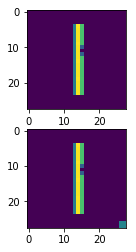

In [6]:
p_train,p_test,p_ind = \
    poison_dataset(train_X,train_y,test_X,test_y,poison_target,
                   poison_target_change_to,poison_prob,
                   poison_prob_test,show=True)

In [7]:
clean_logs = run_without_verify(def_graph,tensor_dict,train_X,train_y,test_X,test_y,
          epoch_seed=128527,poisoned=False,pois_ind = None,log_weights = True)

Epoch 1, Loss= 0.056334, Validation Accuracy= 0.98200
Epoch 2, Loss= 0.039635, Validation Accuracy= 0.98750
Epoch 3, Loss= 0.037051, Validation Accuracy= 0.98950
Epoch 4, Loss= 0.038992, Validation Accuracy= 0.98820
Epoch 5, Loss= 0.040028, Validation Accuracy= 0.98770
Epoch 6, Loss= 0.047303, Validation Accuracy= 0.98570
Epoch 7, Loss= 0.034770, Validation Accuracy= 0.99040
Epoch 8, Loss= 0.041883, Validation Accuracy= 0.98730
Epoch 9, Loss= 0.061839, Validation Accuracy= 0.98340
Epoch 10, Loss= 0.044474, Validation Accuracy= 0.98710
Epoch 11, Loss= 0.040087, Validation Accuracy= 0.99020
Epoch 12, Loss= 0.041958, Validation Accuracy= 0.98910
Epoch 13, Loss= 0.041981, Validation Accuracy= 0.98920
Epoch 14, Loss= 0.037748, Validation Accuracy= 0.99090
Epoch 15, Loss= 0.030828, Validation Accuracy= 0.99180
Epoch 16, Loss= 0.043509, Validation Accuracy= 0.98990
Epoch 17, Loss= 0.032568, Validation Accuracy= 0.99260
Epoch 18, Loss= 0.037488, Validation Accuracy= 0.99200
Epoch 19, Loss= 0.0

In [18]:
import bz2
import pickle
print (clean_logs.keys())
print (len(clean_logs['weights']))
print (len(clean_logs['weights'])/epochs)
print (clean_logs['weights'][0].shape)

mnist_file = 'madeup_mnist/clean_run/'
meta_log = {k: clean_logs[k] for k in ['poisoned_batch_numbers','test_accuracies']}
with bz2.BZ2File(mnist_file+'meta.pickle', 'wb') as f:
    pickle.dump(meta_log, f,protocol=pickle.HIGHEST_PROTOCOL)
batches_per_epoch = len(clean_logs['weights'])//epochs
for c in range(epochs):
    with bz2.BZ2File(mnist_file+'weights_epoch_'+str(c)+'.pickle.bz2', 'wb') as f:
        pickle.dump(clean_logs['weights'][c*(batches_per_epoch):
                                          min((c+1)*batches_per_epoch,
                                              len(clean_logs['weights']))]
                , f,protocol=pickle.HIGHEST_PROTOCOL)

dict_keys(['weights', 'poisoned_batch_numbers', 'bacth_losses', 'batch_accuracies', 'test_losses', 'test_accuracies'])
14040
468.0
(356234,)


In [7]:
prob_configs = [(0.1,6756),(0.01,656587),(0.0015,67524)]
#prob_configs = [(0.01,656587),(0.0015,67524)]
for conf in prob_configs:
    poison_prob = conf[0]
    poison_seed = conf[1]
    print('*- configuration with poison seed {} and poison prob {}'.format
          (poison_seed,poison_prob))
    p_train,p_test,p_ind = \
    poison_dataset(train_X,train_y,test_X,test_y,poison_target,
                   poison_target_change_to,poison_prob,
                   poison_prob_test,show=False)
    poison_logs = run_without_verify(def_graph,tensor_verify_dict,
                                     p_train[0],p_train[1],p_test[0],p_test[1],
              epoch_seed=128527,poisoned=True,pois_ind = p_ind,log_weights=True)
    mnist_file = 'madeup_mnist/poison_run_{}/'.format(poison_prob)
    meta_log = {k: poison_logs[k] for k in ['poisoned_batch_numbers',
                                           'test_accuracies','poisoned_test_accuracies']}
    with bz2.BZ2File(mnist_file+'meta.pickle', 'wb') as f:
        pickle.dump(meta_log, f,protocol=pickle.HIGHEST_PROTOCOL)
    batches_per_epoch = len(poison_logs['weights'])//epochs
    for c in range(epochs):
        with bz2.BZ2File(mnist_file+'weights_epoch_'+str(c)+'.pickle.bz2', 'wb') as f:
            pickle.dump(poison_logs['weights'][c*(batches_per_epoch):
                                               min((c+1)*batches_per_epoch,
                                                   len(poison_logs['weights']))]
                    , f,protocol=pickle.HIGHEST_PROTOCOL)
    poison_logs = None

*- configuration with poison seed 6756 and poison prob 0.1
Epoch 1, Loss= 0.071180, Validation Accuracy= 0.97850
*Attack result: Loss= 0.112548, Validation Accuracy= 0.98387

Epoch 2, Loss= 0.041152, Validation Accuracy= 0.98680
*Attack result: Loss= 0.016375, Validation Accuracy= 1.00000

Epoch 3, Loss= 0.035883, Validation Accuracy= 0.98760
*Attack result: Loss= 0.002124, Validation Accuracy= 1.00000

Epoch 4, Loss= 0.034752, Validation Accuracy= 0.98910
*Attack result: Loss= 0.001050, Validation Accuracy= 1.00000

Epoch 5, Loss= 0.037212, Validation Accuracy= 0.98860
*Attack result: Loss= 0.001399, Validation Accuracy= 1.00000

Epoch 6, Loss= 0.034422, Validation Accuracy= 0.98940
*Attack result: Loss= 0.002770, Validation Accuracy= 1.00000

Epoch 7, Loss= 0.035718, Validation Accuracy= 0.98930
*Attack result: Loss= 0.001132, Validation Accuracy= 1.00000

Epoch 8, Loss= 0.034355, Validation Accuracy= 0.98920
*Attack result: Loss= 0.001446, Validation Accuracy= 1.00000

Epoch 9, Loss

Epoch 9, Loss= 0.286483, Validation Accuracy= 0.96570
*Attack result: Loss= 10.522015, Validation Accuracy= 0.00000

Epoch 10, Loss= 0.276309, Validation Accuracy= 0.96590
*Attack result: Loss= 10.154531, Validation Accuracy= 0.00000

Epoch 11, Loss= 0.250898, Validation Accuracy= 0.96630
*Attack result: Loss= 9.072399, Validation Accuracy= 0.00000

Epoch 12, Loss= 0.158745, Validation Accuracy= 0.96590
*Attack result: Loss= 5.167352, Validation Accuracy= 0.00000

Epoch 13, Loss= 0.093077, Validation Accuracy= 0.97570
*Attack result: Loss= 2.442113, Validation Accuracy= 0.36975

Epoch 14, Loss= 0.113508, Validation Accuracy= 0.97390
*Attack result: Loss= 3.012245, Validation Accuracy= 0.35294

Epoch 15, Loss= 0.117668, Validation Accuracy= 0.97610
*Attack result: Loss= 3.072920, Validation Accuracy= 0.47899

Epoch 16, Loss= 0.090366, Validation Accuracy= 0.98110
*Attack result: Loss= 1.332643, Validation Accuracy= 0.75630

Epoch 17, Loss= 0.056575, Validation Accuracy= 0.98700
*Attack 